In [1]:

import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from datetime import datetime

In [2]:

results_dir = "CODSOFT_02/RESULTS"
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
    print(f"Created directory: {results_dir}")
else:
    print(f"Directory already exists: {results_dir}")

Created directory: CODSOFT_02/RESULTS


In [3]:

train_data = pd.read_csv('Fraud Test Dataset/fraudTrain.csv')
test_data = pd.read_csv('Fraud Test Dataset/fraudTest.csv')

In [4]:

train_data.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [5]:

print("Missing values in training data:")
print(train_data.isnull().sum())
print("\nMissing values in test data:")
print(test_data.isnull().sum())

Missing values in training data:
Unnamed: 0               0
trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
dtype: int64

Missing values in test data:
Unnamed: 0               0
trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state 

In [6]:

def extract_datetime_features(df):
    df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
    df['hour'] = df['trans_date_trans_time'].dt.hour
    df['day'] = df['trans_date_trans_time'].dt.day
    df['month'] = df['trans_date_trans_time'].dt.month
    df['day_of_week'] = df['trans_date_trans_time'].dt.dayofweek
    
    return df

train_data = extract_datetime_features(train_data)
test_data = extract_datetime_features(test_data)

In [7]:

def calculate_distance(df):
    R = 6371  # Earth radius in kilometers

    lat1 = np.radians(df['lat'])
    lon1 = np.radians(df['long'])
    lat2 = np.radians(df['merch_lat'])
    lon2 = np.radians(df['merch_long'])
    
    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    distance = R * c
    
    return distance

train_data['distance'] = calculate_distance(train_data)
test_data['distance'] = calculate_distance(test_data)

In [8]:
def calculate_age(df):
    df['dob'] = pd.to_datetime(df['dob'])
    reference_date = pd.to_datetime('2019-01-01')  # Use a reference date from the dataset
    df['age'] = (reference_date - df['dob']).dt.days // 365
    return df

train_data = calculate_age(train_data)
test_data = calculate_age(test_data)

In [9]:

drop_columns = ['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'street', 
                'city', 'state', 'zip', 'first', 'last', 'job', 'dob', 'trans_num']

# Categorical features that need to be encoded
categorical_features = ['category', 'gender']

# Numeric features that need to be scaled
numeric_features = ['amt', 'lat', 'long', 'city_pop', 'merch_lat', 'merch_long', 
                    'hour', 'day', 'month', 'day_of_week', 'distance', 'age', 'unix_time']

# Prepare X and y
X_train = train_data.drop(drop_columns + ['is_fraud'], axis=1)
y_train = train_data['is_fraud']
X_test = test_data.drop(drop_columns + ['is_fraud'], axis=1)
y_test = test_data['is_fraud']

In [10]:

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [11]:
logistic_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])

decision_tree_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier())
])

random_forest_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier())
])

In [12]:
# Train Logistic Regression model
print("Training Logistic Regression model...")
logistic_pipeline.fit(X_train, y_train)

Training Logistic Regression model...


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['amt', 'lat', 'long',
                                                   'city_pop', 'merch_lat',
                                                   'merch_long', 'hour', 'day',
                                                   'month', 'day_of_week',
                                                   'distance', 'age',
                                                   'unix_time']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['category', 'gender'])])),
                ('classifier', LogisticRegression(max_iter=1000))])

In [13]:
# Train Decision Tree model
print("Training Decision Tree model...")
decision_tree_pipeline.fit(X_train, y_train)

Training Decision Tree model...


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['amt', 'lat', 'long',
                                                   'city_pop', 'merch_lat',
                                                   'merch_long', 'hour', 'day',
                                                   'month', 'day_of_week',
                                                   'distance', 'age',
                                                   'unix_time']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['category', 'gender'])])),
                ('classifier', DecisionTreeClassifier())])

In [14]:
# Train Random Forest model
print("Training Random Forest model...")
random_forest_pipeline.fit(X_train, y_train)

Training Random Forest model...


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['amt', 'lat', 'long',
                                                   'city_pop', 'merch_lat',
                                                   'merch_long', 'hour', 'day',
                                                   'month', 'day_of_week',
                                                   'distance', 'age',
                                                   'unix_time']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['category', 'gender'])])),
                ('classifier', RandomForestClassifier())])

In [15]:

logistic_predictions = logistic_pipeline.predict(X_test)
decision_tree_predictions = decision_tree_pipeline.predict(X_test)
random_forest_predictions = random_forest_pipeline.predict(X_test)

In [16]:

def evaluate_and_save(y_true, y_pred, model_name):
   
    report = classification_report(y_true, y_pred, output_dict=True)
    report_df = pd.DataFrame(report).transpose()
    
    report_path = os.path.join(results_dir, f"{model_name}_classification_report.csv")
    report_df.to_csv(report_path)
    

    print(f'{model_name} Classification Report:')
    print(classification_report(y_true, y_pred))
    print(f"Report saved to: {report_path}")
    

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    

    cm_path = os.path.join(results_dir, f"{model_name}_confusion_matrix.png")
    plt.savefig(cm_path, bbox_inches='tight', dpi=300)
    plt.show()
    print(f"Confusion matrix saved to: {cm_path}")
    

    predictions_df = pd.DataFrame({
        'actual': y_true,
        'predicted': y_pred
    })
    pred_path = os.path.join(results_dir, f"{model_name}_predictions.csv")
    predictions_df.to_csv(pred_path, index=False)
    print(f"Predictions saved to: {pred_path}\n")

logistic_regression Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.01      0.00      0.00      2145

    accuracy                           1.00    555719
   macro avg       0.50      0.50      0.50    555719
weighted avg       0.99      1.00      0.99    555719

Report saved to: CODSOFT_02/RESULTS\logistic_regression_classification_report.csv


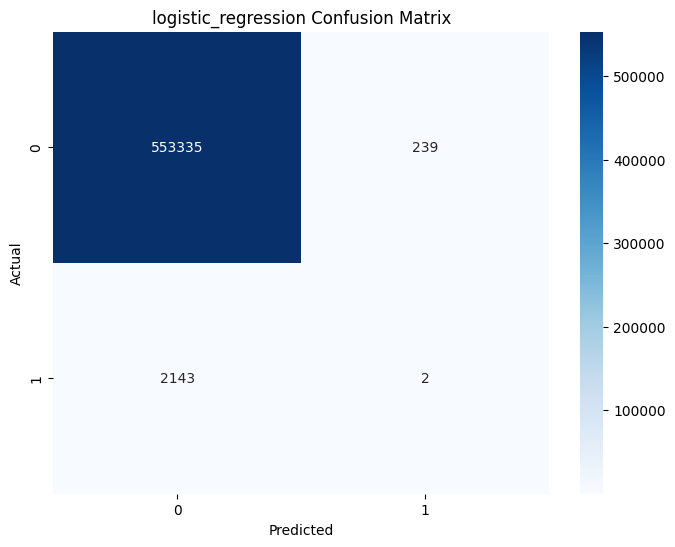

Confusion matrix saved to: CODSOFT_02/RESULTS\logistic_regression_confusion_matrix.png
Predictions saved to: CODSOFT_02/RESULTS\logistic_regression_predictions.csv



In [17]:

evaluate_and_save(y_test, logistic_predictions, "logistic_regression")

decision_tree Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.60      0.81      0.69      2145

    accuracy                           1.00    555719
   macro avg       0.80      0.91      0.84    555719
weighted avg       1.00      1.00      1.00    555719

Report saved to: CODSOFT_02/RESULTS\decision_tree_classification_report.csv


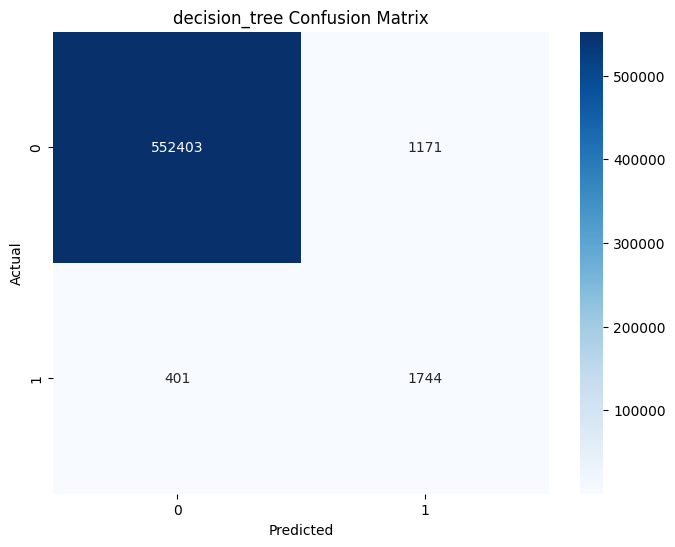

Confusion matrix saved to: CODSOFT_02/RESULTS\decision_tree_confusion_matrix.png
Predictions saved to: CODSOFT_02/RESULTS\decision_tree_predictions.csv



In [18]:

evaluate_and_save(y_test, decision_tree_predictions, "decision_tree")

random_forest Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.96      0.71      0.82      2145

    accuracy                           1.00    555719
   macro avg       0.98      0.86      0.91    555719
weighted avg       1.00      1.00      1.00    555719

Report saved to: CODSOFT_02/RESULTS\random_forest_classification_report.csv


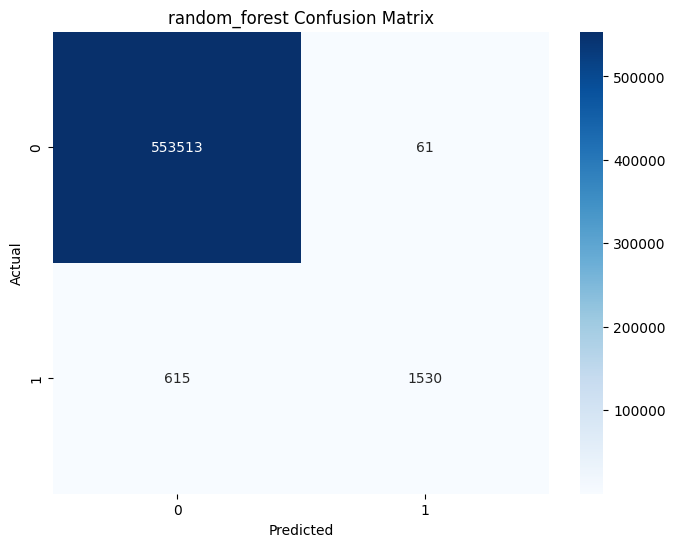

Confusion matrix saved to: CODSOFT_02/RESULTS\random_forest_confusion_matrix.png
Predictions saved to: CODSOFT_02/RESULTS\random_forest_predictions.csv



In [19]:

evaluate_and_save(y_test, random_forest_predictions, "random_forest")

Feature importances saved to: CODSOFT_02/RESULTS\feature_importances.csv


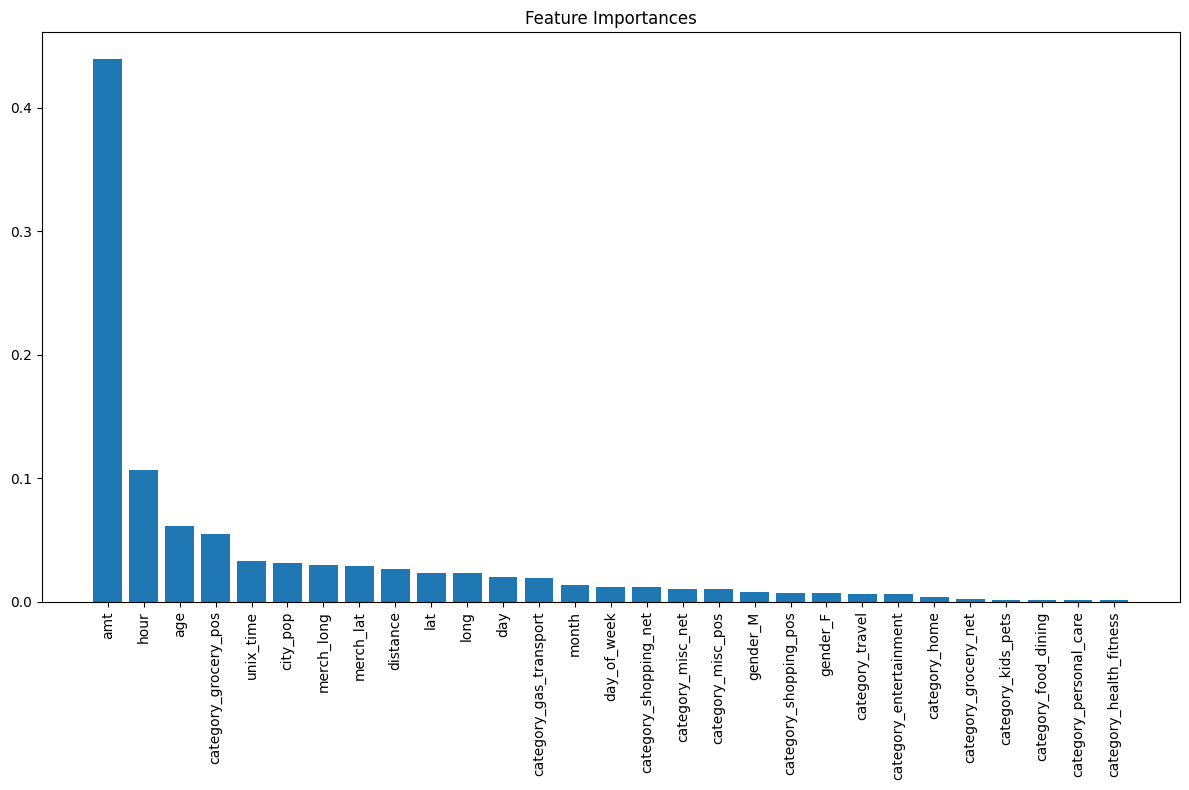

Feature importance plot saved to: CODSOFT_02/RESULTS\feature_importances.png


In [20]:

if hasattr(random_forest_pipeline['classifier'], 'feature_importances_'):
   
    preprocessor = random_forest_pipeline['preprocessor']
    feature_names = []
    

    feature_names.extend(numeric_features)
    

    for cat_feature in categorical_features:
      
        onehotencoder = preprocessor.transformers_[1][1]['onehot']
     
        categories = onehotencoder.categories_
       
        for category in categories[categorical_features.index(cat_feature)]:
            feature_names.append(f"{cat_feature}_{category}")
    
   
    importances = random_forest_pipeline['classifier'].feature_importances_
    
  
    if len(importances) != len(feature_names):
        feature_names = [f"Feature {i}" for i in range(len(importances))]

    indices = np.argsort(importances)[::-1]
   
    importance_df = pd.DataFrame({
        'Feature': [feature_names[i] for i in indices],
        'Importance': importances[indices]
    })
    

    fi_path = os.path.join(results_dir, "feature_importances.csv")
    importance_df.to_csv(fi_path, index=False)
    print(f"Feature importances saved to: {fi_path}")
    

    plt.figure(figsize=(12, 8))
    plt.title("Feature Importances")
    plt.bar(range(len(indices)), importances[indices], align='center')
    plt.xticks(range(len(indices)), [feature_names[i] for i in indices], rotation=90)
    plt.tight_layout()
    
    # Save the plot
    fi_plot_path = os.path.join(results_dir, "feature_importances.png")
    plt.savefig(fi_plot_path, bbox_inches='tight', dpi=300)
    plt.show()
    print(f"Feature importance plot saved to: {fi_plot_path}")

In [21]:

import pickle


def save_model(model, model_name):
    model_path = os.path.join(results_dir, f"{model_name}.pkl")
    with open(model_path, 'wb') as file:
        pickle.dump(model, file)
    print(f"{model_name} model saved to: {model_path}")


save_model(logistic_pipeline, "logistic_regression_model")
save_model(decision_tree_pipeline, "decision_tree_model")
save_model(random_forest_pipeline, "random_forest_model")

logistic_regression_model model saved to: CODSOFT_02/RESULTS\logistic_regression_model.pkl
decision_tree_model model saved to: CODSOFT_02/RESULTS\decision_tree_model.pkl
random_forest_model model saved to: CODSOFT_02/RESULTS\random_forest_model.pkl


In [22]:

def get_model_metrics(y_true, y_pred):
    report = classification_report(y_true, y_pred, output_dict=True)
    return {
        'accuracy': report['accuracy'],
        'precision': report['weighted avg']['precision'],
        'recall': report['weighted avg']['recall'],
        'f1-score': report['weighted avg']['f1-score']
    }


lr_metrics = get_model_metrics(y_test, logistic_predictions)
dt_metrics = get_model_metrics(y_test, decision_tree_predictions)
rf_metrics = get_model_metrics(y_test, random_forest_predictions)


summary_data = {
    'Model': ['Logistic Regression', 'Decision Tree', 'Random Forest'],
    'Accuracy': [lr_metrics['accuracy'], dt_metrics['accuracy'], rf_metrics['accuracy']],
    'Precision': [lr_metrics['precision'], dt_metrics['precision'], rf_metrics['precision']],
    'Recall': [lr_metrics['recall'], dt_metrics['recall'], rf_metrics['recall']],
    'F1-Score': [lr_metrics['f1-score'], dt_metrics['f1-score'], rf_metrics['f1-score']]
}

summary_df = pd.DataFrame(summary_data)


summary_path = os.path.join(results_dir, "model_performance_summary.csv")
summary_df.to_csv(summary_path, index=False)
print(f"Model performance summary saved to: {summary_path}")


summary_df

Model performance summary saved to: CODSOFT_02/RESULTS\model_performance_summary.csv


,Model,Accuracy,Precision,Recall,F1-Score
0,Logistic Regression,0.995714,0.992329,0.995714,0.994007
1,Decision Tree,0.997171,0.997727,0.997171,0.997385
2,Random Forest,0.998784,0.998746,0.998784,0.998694
